# Read dataset and create data loaders

In [25]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [26]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
'''
# Initialise vectors and batch size
transform= transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
batch_size=4
# Load training and testing dataset
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [28]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1= nn.Conv2d(3,6,5)
#     self.pool= nn.MaxPool2d(2,2)
#     self.conv2= nn.Conv2d(6,16,5)
#     self.fc1= nn.Linear(16 * 5 * 5, 120)
#     self.fc2=nn.Linear(120,84)
#     self.fc3=nn.Linear(84,10)

#   def forward(self,x):
#     x= self.pool(F.relu(self.conv1(x)))
#     x= self.pool(F.relu(self.conv2(x)))
#     x= torch.flatten(x,1)
#     x= F.relu(self.fc1(x))
#     x= F.relu(self.fc2(x))
#     x= self.fc3(x)
#     return x

In [29]:
import torch.nn as nn
import torch.nn.functional as F
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self) -> None:
     super(Stem,self).__init__()
     self.stem = nn.Sequential(
       nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(64), 
       nn.ReLU(inplace=True),
       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(64),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
       nn.BatchNorm2d(128),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    # print("Stem output shape in forward pass:", x.shape)
    return x

## Block

In [30]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k=4, r=4):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

In [31]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k=4, r=4, kernel_size=3, stride=1, padding=1):
    super(Block, self).__init__()
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)
    # Input from first block
    # Input from previous block for rest
    # Generate vector a with K elements from X as a= E(X)
    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

  def forward(self,x):
    a = self.expertBranch(x)
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)
    a= a.view(a.size(0), self.k, 1,1,1)

    out = (a* stacked).sum(dim=1)

    return out

## Backbone

In [32]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels=64, hidden_channels=64, num_blocks=3, k=4, r=4):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
      x = block(x)
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
    return x

## Classifier

In [33]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes=10, use_mlp=False):
    super(Classifier,self).__init__()
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(0.3), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    # print("Classifier input shape:", x.shape)
    out = self.classifier(x)
    # print("Classifier output shape (logits):", out.shape)
    return out


# Model

In [34]:
class Model(nn.Module):
  def __init__(self, stem_channels= 128, hidden_channels=128, num_blocks=3, k=4, r=4, num_classes=10, use_mlp=False):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem()
    # Call backbone
    self.backbone= Backbone(input_channels=stem_channels, hidden_channels= hidden_channels, num_blocks=num_blocks, k=k, r=r)
    # Call classifier
    self.classifier= Classifier(input_channels=hidden_channels, num_classes=num_classes, use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [35]:
model = Model(
    stem_channels=128,
    hidden_channels=128,
    num_blocks=3,
    k=4,
    r=4,
    num_classes=10,
    use_mlp=True
)


criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training


Epoch 1/10


Train Loss: 2.0095 | Accuracy: 18.67%
Val   Loss: 1.7381 | Accuracy: 28.35%
Saved best model.

Epoch 2/10


Train Loss: 1.7577 | Accuracy: 29.04%
Val   Loss: 1.6416 | Accuracy: 34.10%
Saved best model.

Epoch 3/10


Train Loss: 1.6343 | Accuracy: 36.63%
Val   Loss: 1.4370 | Accuracy: 44.79%
Saved best model.

Epoch 4/10


Train Loss: 1.5155 | Accuracy: 43.67%
Val   Loss: 1.3504 | Accuracy: 49.12%
Saved best model.

Epoch 5/10


Train Loss: 1.4353 | Accuracy: 47.68%
Val   Loss: 1.3308 | Accuracy: 50.16%
Saved best model.

Epoch 6/10


Train Loss: 1.3853 | Accuracy: 50.06%
Val   Loss: 1.3116 | Accuracy: 54.08%
Saved best model.

Epoch 7/10


Train Loss: 1.3524 | Accuracy: 52.03%
Val   Loss: 1.2094 | Accuracy: 56.82%
Saved best model.

Epoch 8/10


Train Loss: 1.3228 | Accuracy: 53.22%
Val   Loss: 1.2619 | Accuracy: 55.88%

Epoch 9/10


Train Loss: 1.2925 | Accuracy: 54.38%
Val   Loss: 1.2212 | Accuracy: 56.34%

Epoch 10/10


Train Loss: 1.2643 | Accuracy: 55.73%
Val   Loss: 1.1728 | Accuracy: 56.89%
Saved best model.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 1.4970
Average Train Accuracy: 44.11%
Average Val   Loss: 1.3675
Average Val   Accuracy: 48.65%
Plots saved: loss_curve.png and accuracy_curve.png


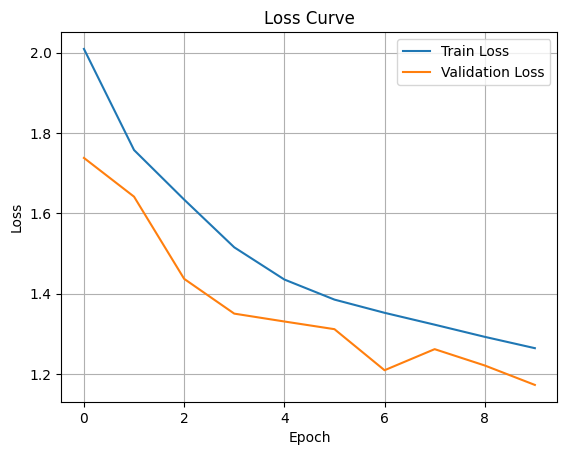

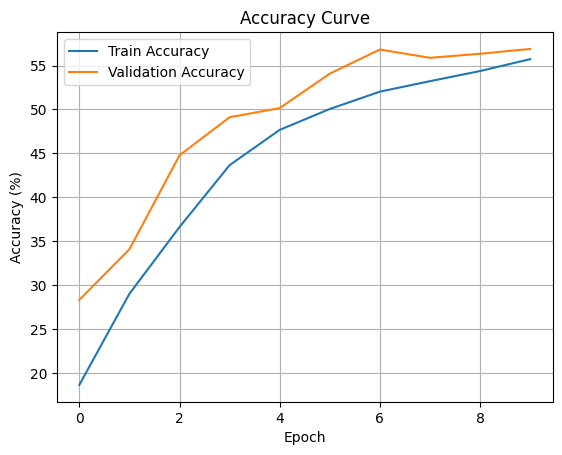

In [36]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# ---------- Log training ----------
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# ---------- Training + Validation Loops ----------
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# ---------- 5. Main Loop ----------
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")

print("\nTraining Complete")

# ---------- 8. Print Final Averages ----------
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# ---------- 7. Plot Results ----------

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")


Averages:


*   Train Loss: 1.7223, Accuracy: 38.21%, Validation Loss: 1.7194, Accuracy: 38.25%
*   Train Loss: 1.7106, Accuracy: 34.80%, Validation Loss: 1.7984, Accuracy: 35.98%

*   Train Loss: 1.8150, Accuracy: 34.54%, Val   Loss: 1.7848 Accuracy: 36.13%

*   Train Loss: 1.9579, Accuracy: 28.84%, Val   Loss: 1.8691, Accuracy: 32.51%
*   Train Loss: 1.9712, Accuracy: 27.54%, Val   Loss: 1.9107 ,Accuracy: 30.24%
*   Train Loss: 2.1609, Accuracy: 16.97%, Val   Loss: 2.1343, Accuracy: 18.28%
*   Train Loss: 1.9798, Accuracy: 27.24%, Val   Loss: 1.9312, Accuracy: 29.65%
*   Train Loss: 1.4970, Accuracy: 44.11%, Val   Loss: 1.3675, Accuracy: 48.65%




# Test training data